In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [18]:
np.random.seed(923)
n = 6000  # number of simulated units

# --- 1. Simulate mcrsharee1983 with 30% zeros and 70% in (0,1) ---
mcrsharee1983 = np.zeros(n)
treated_mask = np.random.rand(n) > 0.30  # 70% get non-zero share
mcrsharee1983[treated_mask] = np.random.beta(5, 6, size=treated_mask.sum())

# Quadratic treatment effect, which will be baked into deprshare and bintechcount
tau_cl = 1 - 0.5*(2*mcrsharee1983-1)**2
tau_tech = 4- 0.5*(2*mcrsharee1983-1)**2


# --- 2. Simulate deprshare1980–1986 with tau baked into 1984–1986 ---
deprshares = {}
for year in range(1980, 1987):
    base = np.random.normal(4 + 0.2 * (year - 1980), 2.5, size=n)
    if year >= 1984:
        base += tau_cl 
    deprshares[f'deprshare{year}'] = np.clip(base, 0, 100)

# --- 3. Simulate bintechcount1980–1986 as integer counts with tau baked into 1984–1986 ---
bintechcounts = {}
for i, year in enumerate(range(1980, 1987)):
    base_mean = 25 + (year - 1980)  # increasing mean over time
    base = np.random.normal(base_mean, 15, size=n)
    if year >= 1984:
        base += tau_tech 
    bintechcounts[f'bintechcount{year}'] = np.clip(np.round(base), 0, 100).astype(int)


# --- 4. Simulate continuous + binary covariates ---
bdtot = np.random.normal(200, 200, size=n)
totms = np.random.normal(100, 100, size=n)
private1983 = np.random.binomial(1, 0.6, size=n)
msa1983 = np.random.binomial(1, 0.5, size=n)

# --- 5. Simulate st10–st48 one-hot state dummies ---
st_cols = [f'st{i}' for i in range(10, 49)]
st_matrix = np.zeros((n, len(st_cols)), dtype = int)
chosen_states = np.random.choice(len(st_cols), size=n)
for i, s in enumerate(chosen_states):
    st_matrix[i, s] = 1
st_df = pd.DataFrame(st_matrix, columns=st_cols)

# --- 6. Simulate 9 tech dummies ---
tech_cols = ['open_heart_tech1983', 'catheterization_tech1983', 'radioiso_diag_tech1983',
             'radio_implants_tech1983', 'radioiso_ther_tech1983', 'xray_ther_tech1983',
             'megavolt_tech1983', 'organ_transplant_tech1983', 'ct_tech1983']
tech_df = pd.DataFrame(np.random.binomial(1, 0.3, size=(n, len(tech_cols))), columns=tech_cols)

# --- 7. Assemble full DataFrame ---
df_sim = pd.DataFrame({
    'mcrsharee1983': mcrsharee1983,
    'bdtot1983': bdtot,
    'totms1983': totms,
    'private1983': private1983,
    'msa1983': msa1983
})
df_sim = pd.concat([
    df_sim,
    pd.DataFrame(deprshares),
    pd.DataFrame(bintechcounts),
    st_df,
    tech_df
], axis=1)

# --- 8. Match df_main column order exactly ---
df_vars = (
    [f'deprshare{i}' for i in range(1980, 1987)] +
    [f'bintechcount{i}' for i in range(1980, 1987)] +
    ['mcrsharee1983', 'bdtot1983', 'totms1983', 'private1983', 'msa1983'] +
    st_cols + tech_cols
)
df_sim = df_sim[df_vars]

In [19]:
# --- Export data to csv (should be in the same directory as where the Jupyter notebook is located)
df_sim.to_csv("ppsreplicationdata_simulated.csv", index=False)

In [20]:
# --- Now df_sim mimics df_main exactly
df_sim.head()

deprshare1980  deprshare1981  deprshare1982  deprshare1983  deprshare1984  \
0       5.151917       2.166601       3.039583       4.519645       3.055672   
1       1.459992       0.989867       0.000000       8.648418       3.971911   
2       3.608329       4.194742       5.235346       0.414681       4.825809   
3       2.913305       8.310639       2.149501       3.470897       4.004727   
4       2.719057       0.961900       4.080290       4.040181       3.981682   

   deprshare1985  deprshare1986  bintechcount1980  bintechcount1981  \
0       5.795765       5.165730                 3                33   
1      10.228455       2.795892                 6                 0   
2       3.256308       4.456675                 5                34   
3       0.336987       8.854215                13                14   
4       9.035677       5.381902                 0                16   

   bintechcount1982  ...  st48  open_heart_tech1983  catheterization_tech1983  \
0                 9  ...     0                    0                         1   
1                43  ...     1                    1                         0   
2                31  ...     0                    0                         0   
3                41  ...     0                    0                         1   
4                51  ...     1                    1                         0   

   radioiso_diag_tech1983  radio_implants_tech1983  radioiso_ther_tech1983  \
0                       0                        0                       1   
1                       0                        0                       0   
2                       1                        0                       0   
3                       0                        0                       0   
4                       0                        0                       1   

   xray_ther_tech1983  megavolt_tech1983  organ_transplant_tech1983  \
0                   1                  0                          1   
1                   0                  0                          1   
2                   0                  1                          0   
3                   0                  1                          1   
4                   0                  1                          0   

   ct_tech1983  
0            1  
1            0  
2            0  
3            0  
4            1  

[5 rows x 67 columns]

Selected undersmoothed bandwidth: 0.0266


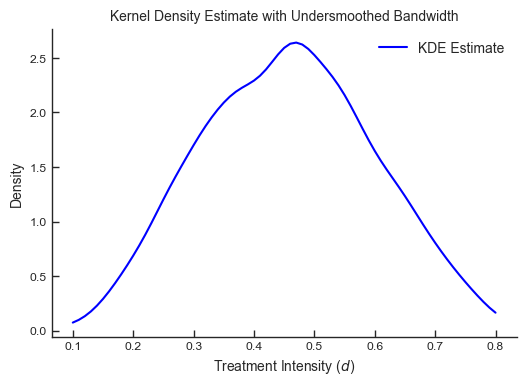

In [4]:
# --- Optional: plot the kernel density of positive treatment intensity ---

# Set seaborn theme for better aesthetics
sns.set_theme()
sns.set_context("paper")
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})

# Extract positive D values
D_positive = df_sim[df_sim.mcrsharee1983 > 0].mcrsharee1983.to_numpy()

# # Define a range of bandwidths for cross-validation search
bandwidths = np.linspace(0.001, 0.5, 40)

# # Set cross-validation with controlled randomness
cv = KFold(n_splits=5, shuffle=True, random_state=923)

# # Perform GridSearchCV with fixed seed
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=cv)
grid.fit(D_positive[:, None])

# # Retrieve the optimal bandwidth and apply undersmoothing (3/4 factor)
h = np.round(grid.best_params_['bandwidth'], 4)
print(f"Selected undersmoothed bandwidth: {h}")

# Fit KDE with the selected bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(D_positive[:, None])

# Define evaluation points (dlist)
dlist = np.round(np.linspace(0.1, 0.8, 71), 2).tolist()
dlist_arr = np.array(dlist)[:, None]  # Convert to 2D array for KDE input

# Compute KDE estimates
log_dens = kde.score_samples(dlist_arr)
density_values = np.exp(log_dens)  # Convert log-density to actual density

# Plot KDE on dlist
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dlist, density_values, color='blue', linewidth=1.5, label="KDE Estimate")
ax.set_xlabel(r'Treatment Intensity ($d$)', fontsize=10)
ax.set_ylabel(r'Density', fontsize=10)
ax.set_title(r'Kernel Density Estimate with Undersmoothed Bandwidth', fontsize=10)

# Improved legend
ax.legend(fontsize=10, loc='upper right', frameon=False)

# Remove top and right spines for cleaner look
sns.despine()

# Show the plot
plt.show()